# Predicting Oscar Best Picture Nominations And Winners

## Objective
This project is an exercise in trying to predict the winners and nominations of the Best Picture category of the Oscars using past data, utilizing features scraped from IMDB, mainly genre, country, average rating, duration, and number of votes to denote popularity.\
This is done primarily through a variety of classification algorithms (Logistic Regression, Decision Tree/Random Forest, K Nearest Neighbors, and Naive Bayes).\
I try to fit these models with the best hyperparameters for each method and evaluate based on accuracy, Jaccard Index, and F1 Score.\
The end goal is to see if there are decent enough features from just the IMDB dataset to determine which films have the best chances of winning and/or being nominated.

## Table Of Contents
<ol>
    <li><a href='#Loading-Data-and-Data-Preprocessing'>Loading Data and Data Preprocessing</a></li>
    <li><a href='#Exploratory-Data-Analysis'>Exploratory Data Analysis</a></li>
    <li><a href='#Machine-Learning-And-Model-Evaluation'>Machine Learning And Model Evaluation</a></li>
    <li><a href='#Predicting-Nominations-and-Winner-of-2020'>Predicting Nominations and Winner of 2020</a></li>
    <li><a href='#Final-Results-and-Next-Steps'>Final Results and Next Steps</a></li>
</ol>

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re
import seaborn as sns
%matplotlib inline


## Loading Data and Data Preprocessing
First we have to load the datasets required. In our case, we are using 3 CSVs. 1 is of the movies from IMDB that have over 100 votes until 2020, 1 is of the Oscar winners by category, and 1 is scraped from IMDB such that the data is approximately the same as the Kaggle one.\
https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset \
https://www.kaggle.com/unanimad/the-oscar-award \
<a href="../JB Notebooks/Scrape IMDB.ipynb">Code For Scraping IMDB</a>

The plan then is to combine all of these datasets into one DataFrame after some merging and data manipulation.\

### Merging Data

In [2]:
%%capture
df1 = pd.read_csv("../JB Notebooks/IMDb/IMDb movies.csv") #Use the link to DL the csv
df2 = pd.read_csv('../JB Notebooks/IMDb/2020 movies onwards.csv') #from Scrape IMDB.jpynb
df3 = pd.read_csv('../JB Notebooks/IMDb/the_oscar_award.csv')

In [3]:
#Combine the two datasets from before 2020 and after 2020
df2.original_title = df2.title
df = pd.concat([df1,df2])

In [4]:
#Check for duplicates
df.duplicated('imdb_title_id').value_counts()

False    87090
True       782
dtype: int64

In [5]:
#Drop duplicates and unnecessary features, keeping the latest data
df = df.drop_duplicates('imdb_title_id', keep='last')
movies_df = df.drop(columns=['title','date_published','director','writer','actors','description','budget','production_company','usa_gross_income','worlwide_gross_income','reviews_from_users','reviews_from_critics','Unnamed: 0'])

In [6]:
#Fix some values in the year column
movies_df.loc[movies_df['year'] == 'TV Movie 2019','year'] = '2019'
movies_df = movies_df.astype({'year':'int64'})

Now we work on the Oscar winners DataFrame. We merge this DataFrame with the previous DataFrame with data from IMDB on the film titles and year.

In [7]:
#Aggregate by winners of Best Picture and remove other columns
winners_df = df3[df3['category'].isin(['OUTSTANDING PICTURE','OUTSTANDING MOTION PICTURE','BEST PICTURE','BEST MOTION PICTURE','OUTSTANDING PRODUCTION'])]
winners_df = winners_df.drop(columns=['category','name','ceremony','year_ceremony'])

In [8]:
#Merge on Film Title And Year with the previously constructed DataFrame from IMDB
winners_df.rename(columns={'year_film':'year', 'film':'title'}, inplace = True)
total_df = pd.merge(movies_df, winners_df, how='outer', left_on=['original_title','year'], right_on=['title','year'])

#Null values that weren't merged properly
unmerged = total_df[total_df['imdb_title_id'].isnull()]
unmerged

,imdb_title_id,original_title,year,genre,duration,country,language,avg_vote,votes,metascore,title,winner
87090,NaN,NaN,1927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The Racket,False
87091,NaN,NaN,1928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alibi,False
87092,NaN,NaN,1928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The Broadway Melody,True
87093,NaN,NaN,1928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hollywood Revue,False
87094,NaN,NaN,1928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The Patriot,False
...,...,...,...,...,...,...,...,...,...,...,...,...
87154,NaN,NaN,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The Hurt Locker,True
87155,NaN,NaN,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Precious: Based on the Novel 'Push' by Sapphire,False
87156,NaN,NaN,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Three Billboards outside Ebbing, Missouri",False
87157,NaN,NaN,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Once upon a Time...in Hollywood,False


### Handling Null Values

We see that there are Oscar winners that did not merge with the IMDB data. This is either due to wrong/misspelled titles or mismatched years.\
We have to manually add these values into the merged DataFrame and denote which films were winners.

In [9]:
total_df.loc[(total_df['original_title'] == 'The Racket') & (total_df['year'] == 1928),['winner']] = False
total_df.loc[(total_df['original_title'] == 'Alibi') & (total_df['year'] == 1929),['winner']] = False
total_df.loc[(total_df['original_title'] == 'The Broadway Melody') & (total_df['year'] == 1929),['winner']] = True
total_df.loc[(total_df['original_title'] == 'Casablanca') & (total_df['year'] == 1942),['winner']] = True
total_df.loc[(total_df['original_title'] == 'In Which We Serve') & (total_df['year'] == 1942),['winner']] = False
total_df.loc[(total_df['original_title'] == 'The Ox-Bow Incident') & (total_df['year'] == 1942),['winner']] = False
total_df.loc[(total_df['original_title'] == 'The Music Man') & (total_df['year'] == 1962),['winner']] = False
total_df.loc[(total_df['original_title'] == 'How the West Was Won') & (total_df['year'] == 1962),['winner']] = False
total_df.loc[(total_df['original_title'] == 'Alexis Zorbas') & (total_df['year'] == 1964),['winner']] = False
total_df.loc[(total_df['original_title'] == 'The Russians Are Coming the Russians Are Coming') & (total_df['year'] == 1966),['winner']] = False
total_df.loc[(total_df['original_title'] == 'MASH') & (total_df['year'] == 1970),['winner']] = False
total_df.loc[(total_df['original_title'] == 'Utvandrarna') & (total_df['year'] == 1971),['winner']] = False
total_df.loc[(total_df['original_title'] == 'Viskningar och rop') & (total_df['year'] == 1972),['winner']] = False
total_df.loc[(total_df['original_title'] == 'The Godfather: Part II') & (total_df['year'] == 1974),['winner']] = True
total_df.loc[(total_df['original_title'] == "One Flew Over the Cuckoo's Nest") & (total_df['year'] == 1975),['winner']] = True
total_df.loc[(total_df['original_title'] == "Tess") & (total_df['year'] == 1979),['winner']] = False
total_df.loc[(total_df['original_title'] == "Atlantic City") & (total_df['year'] == 1980),['winner']] = False
total_df.loc[(total_df['original_title'] == "E.T. the Extra-Terrestrial") & (total_df['year'] == 1982),['winner']] = False
total_df.loc[(total_df['original_title'] == "A Room with a View") & (total_df['year'] == 1985),['winner']] = False
total_df.loc[(total_df['original_title'] == "My Left Foot: The Story of Christy Brown") & (total_df['year'] == 1989),['winner']] = False
total_df.loc[(total_df['original_title'] == "Dances with Wolves") & (total_df['year'] == 1989),['winner']] = True
total_df.loc[(total_df['original_title'] == "The Godfather: Part III") & (total_df['year'] == 1990),['winner']] = False
total_df.loc[(total_df['original_title'] == "Goodfellas") & (total_df['year'] == 1990),['winner']] = False
total_df.loc[(total_df['original_title'] == "Il postino") & (total_df['year'] == 1994),['winner']] = False
total_df.loc[(total_df['original_title'] == "La vita è bella") & (total_df['year'] == 1997),['winner']] = False
total_df.loc[(total_df['original_title'] == "Wo hu cang long") & (total_df['year'] == 2000),['winner']] = False
total_df.loc[(total_df['original_title'] == "Moulin Rouge!") & (total_df['year'] == 2001),['winner']] = False
total_df.loc[(total_df['original_title'] == "Crash") & (total_df['year'] == 2004),['winner']] = True
total_df.loc[(total_df['original_title'] == "The Hurt Locker") & (total_df['year'] == 2008),['winner']] = True
total_df.loc[(total_df['original_title'] == "Precious") & (total_df['year'] == 2009),['winner']] = False
total_df.loc[(total_df['original_title'] == "Three Billboards Outside Ebbing, Missouri") & (total_df['year'] == 2017),['winner']] = False
total_df.loc[(total_df['original_title'] == "Once Upon a Time... in Hollywood") & (total_df['year'] == 2019),['winner']] = False
total_df.loc[(total_df['original_title'] == "Gisaengchung") & (total_df['year'] == 2019),['winner']] = True
total_df.loc[(total_df['original_title'] == "All Quiet on the Western Fronts") & (total_df['year'] == 1930),['winner']] = True
total_df.loc[(total_df['original_title'] == "The Big House") & (total_df['year'] == 1929),['winner']] = False
total_df.loc[(total_df['original_title'] == "The Divorcee") & (total_df['year'] == 1929),['winner']] = False
total_df.loc[(total_df['original_title'] == "Cimarron") & (total_df['year'] == 1931),['winner']] = True
total_df.loc[(total_df['original_title'] == "East Lynne") & (total_df['year'] == 1931),['winner']] = False
total_df.loc[(total_df['original_title'] == "The Front Page") & (total_df['year'] == 1931),['winner']] = False
total_df.loc[(total_df['original_title'] == "Skippy") & (total_df['year'] == 1931),['winner']] = False
total_df.loc[(total_df['original_title'] == "Trader Horn") & (total_df['year'] == 1931),['winner']] = False
total_df.loc[(total_df['original_title'] == "Grand Hotel") & (total_df['year'] == 1932),['winner']] = True
total_df.loc[(total_df['original_title'] == "One Hour with You") & (total_df['year'] == 1932),['winner']] = False
total_df.loc[(total_df['original_title'] == "Cavalcade") & (total_df['year'] == 1933),['winner']] = True
total_df.loc[(total_df['original_title'] == "42nd Street") & (total_df['year'] == 1933),['winner']] = False
total_df.loc[(total_df['original_title'] == "Lady for a Day") & (total_df['year'] == 1933),['winner']] = False
total_df.loc[(total_df['original_title'] == "Little Women") & (total_df['year'] == 1933),['winner']] = False
total_df.loc[(total_df['original_title'] == "The Private Life of Henry VIII.") & (total_df['year'] == 1933),['winner']] = False
total_df.loc[(total_df['original_title'] == "She Done Him Wrong") & (total_df['year'] == 1933),['winner']] = False
total_df.loc[(total_df['original_title'] == "State Fair") & (total_df['year'] == 1933),['winner']] = False
total_df.loc[(total_df['original_title'] == "The White Parade") & (total_df['year'] == 2009),['winner']] = False
total_df.loc[(total_df['original_title'] == "The Personal History, Adventures, Experience, & Observation of David Copperfield the Younger") & (total_df['year'] == 1935),['winner']] = False
total_df.loc[(total_df['original_title'] == "Les Misérables") & (total_df['year'] == 1935),['winner']] = False
total_df.loc[(total_df['original_title'] == "A Tale of Two Cities") & (total_df['year'] == 1935),['winner']] = False
total_df.loc[(total_df['original_title'] == "In Which We Serve") & (total_df['year'] == 1942),['winner']] = False
total_df.loc[(total_df['original_title'] == "The Chronicle History of King Henry the Fifth with His Battell Fought at Agincourt in France") & (total_df['year'] == 1944),['winner']] = False
total_df.loc[(total_df['original_title'] == "Great Expectations") & (total_df['year'] == 1946),['winner']] = False
total_df.loc[(total_df['original_title'] == "All About Eve") & (total_df['year'] == 1950),['winner']] = True
total_df.loc[(total_df['original_title'] == "Decision Before Dawn") & (total_df['year'] == 1951),['winner']] = False
total_df.loc[(total_df['original_title'] == "La grande illusion") & (total_df['year'] == 1937),['winner']] = False


In [10]:
#Add a nominated column by setting all the films that weren't winners to True from the Oscars DF
total_df['nominated'] = ~total_df['winner'].isnull()
merged = total_df[~total_df['imdb_title_id'].isnull()]
merged = merged.drop('title',axis=1) #drop additional title column

Now we drop the films in the DF that don't have values in genre, duration, language, country, avg_vote, or metascore. We also change all NaN values in winner and nominated to False.

In [11]:
merged = merged.drop(merged[merged['genre'].isna()].index)
merged = merged.drop(merged[merged['duration'].isna()].index)
merged = merged.drop(merged[merged['language'].isna()].index)
merged = merged.drop(merged[merged['language'].str.contains('None')].index)
merged = merged.drop(merged[merged['country'].isna()].index)
merged = merged.drop(merged[merged['avg_vote'].isna()].index)
merged.loc[merged['metascore'].isna(),'metascore'] = merged['avg_vote'].mul(10) #We fill in the missing metascores with avg rating * 10 for simplicity.
merged['winner'].fillna(False, inplace=True)
merged[['winner','nominated']] = merged[['winner','nominated']].astype('int64')

In [12]:
merged = merged.reset_index().drop('index', axis=1)

In [13]:
#We change each of the features with multiple values into lists so that we can use One-Hot Encoding later on these categories
merged['country'] = merged['country'].str.split(', ')
merged['genre'] = merged['genre'].str.split(', ')
merged['language'] = merged['language'].str.split(', ')

In [14]:
merged.index = merged['imdb_title_id']
merged = merged.drop(columns=['imdb_title_id'])
merged = merged.rename_axis(None)

merged

,original_title,year,genre,duration,country,language,avg_vote,votes,metascore,winner,nominated
tt0002101,Cleopatra,1912,"[Drama, History]",100.0,[USA],[English],5.2,446.0,52.0,0,0
tt0002130,L'Inferno,1911,"[Adventure, Drama, Fantasy]",68.0,[Italy],[Italian],7.0,2237.0,70.0,0,0
tt0002199,"From the Manger to the Cross; or, Jesus of Naz...",1912,"[Biography, Drama]",60.0,[USA],[English],5.7,484.0,57.0,0,0
tt0002423,Madame DuBarry,1919,"[Biography, Drama, Romance]",85.0,[Germany],[German],6.8,753.0,68.0,0,0
tt0002445,Quo Vadis?,1913,"[Drama, History]",120.0,[Italy],[Italian],6.2,273.0,62.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
tt11355340,Bangaru Bullodu,2021,[Drama],129.0,[India],[Telugu],5.7,121.0,57.0,0,0
tt11760270,BIR,2020,"[Action, Drama, Thriller]",142.0,[Bangladesh],[Bengali],4.9,206.0,49.0,0,0
tt12737834,Plaza,2020,[Drama],82.0,[Turkey],[Turkish],5.3,106.0,53.0,0,0
tt12357296,Un tal Alonso Quijano,2020,[Drama],102.0,[Colombia],[Spanish],6.2,105.0,62.0,0,0


## Exploratory Data Analysis

Let's examine some characteristics of the features and how each are distributed with respect to winners and nominations.

### Correlation Matrix
First, we check the correlation matrix to see if any feature has a linear relationship with each other or with winner/nominated.

In [15]:
merged.corr()

,year,duration,avg_vote,votes,metascore,winner,nominated
year,1.000000,0.171592,-0.214125,0.057386,-0.235421,-0.026438,-0.067593
duration,0.171592,1.000000,0.243833,0.126308,0.209168,0.052522,0.089626
avg_vote,-0.214125,0.243833,1.000000,0.166974,0.902199,0.049346,0.108849
votes,0.057386,0.126308,0.166974,1.000000,0.083332,0.201762,0.285167
metascore,-0.235421,0.209168,0.902199,0.083332,1.000000,0.058016,0.120291
winner,-0.026438,0.052522,0.049346,0.201762,0.058016,1.000000,0.401922
nominated,-0.067593,0.089626,0.108849,0.285167,0.120291,0.401922,1.000000


We see that besides the expected linear relationships (avg_vote with metascore) and (winner with nominated), we don't have much in terms of features being too linearly correlated with each other.
However, there is also not a strong correlation between winner/nominated with any of the other features. We can show this in the heatmap.

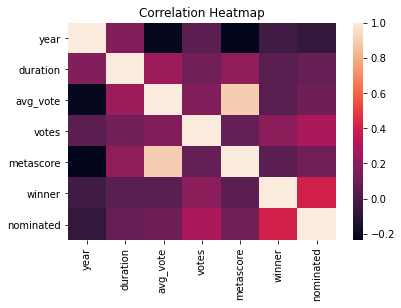

In [16]:
merged_corr = merged.corr()
sns.heatmap(merged_corr)
plt.title('Correlation Heatmap')
plt.show()

In [17]:
merged.describe()

,year,duration,avg_vote,votes,metascore,winner,nominated
count,86020.000000,86020.000000,86020.000000,8.602000e+04,86020.000000,86020.000000,86020.000000
mean,1993.914311,100.442548,5.897179,9.521336e+03,57.805813,0.001035,0.006371
std,24.023091,22.414054,1.235859,5.354427e+04,13.589289,0.032149,0.079562
min,1911.000000,41.000000,1.000000,9.900000e+01,1.000000,0.000000,0.000000
25%,1979.000000,88.000000,5.200000,2.050000e+02,50.000000,0.000000,0.000000
50%,2003.000000,96.000000,6.100000,4.870000e+02,60.000000,0.000000,0.000000
75%,2013.000000,108.000000,6.800000,1.789000e+03,67.000000,0.000000,0.000000
max,2021.000000,808.000000,9.900000,2.278845e+06,100.000000,1.000000,1.000000


### One-Hot Encoding

Before we can explore the categorical columns, we have to do some encoding on those features with multiple values.\
In this case, I decided to one-hot encode the Genre and the Country and omitted the Language. Language and Country are already closely correlated, and one-hot encoding both would have created too many features, even after dimesionality reduction.

In [18]:
#Manual One-Hot Encoding on genre
df = merged.copy()
for index, row in df.iterrows():
    for genre in row['genre']:
        df.at[index, genre] = 1
count_genres = df.shape[1] - len(merged.columns)

#Manual One-Hot Encoding on country
for index, row in df.iterrows():
    for country in row['country']:
        df.at[index, country] = 1
count_country = df.shape[1] - len(merged.columns) - count_genres
        
df.fillna(0, inplace=True)

In [19]:
#Generate list of genres and list of countries as indices for easier access
genre_list = df.columns[len(merged.columns):(len(merged.columns) + count_genres)]
country_list = df.columns[(len(merged.columns) + count_genres):]

Now I decided to remove the columns that only had 1 film for genre or country, i.e. the outliers. This would reduce the chance of overfitting in the models ahead. We then fix the indices for genre and country.

In [20]:
#Find genres/countries that only have 1 film
genre_out = df[genre_list].loc[:,(df[genre_list].sum() < 2)].columns
country_out = df[country_list].loc[:,(df[country_list].sum() < 2)].columns

#Drop those columns
df.drop(genre_out, axis=1, inplace=True)
df.drop(country_out, axis=1, inplace=True)

#Fix genre/country column indices
genre_list = genre_list.drop(genre_out)
country_list = country_list.drop(country_out)

#Remove those films that were outliers that had those values from before
df.drop(index=df[df[genre_list].sum(axis=1) == 0].index, inplace=True)
df.drop(index=df[df[country_list].sum(axis=1) == 0].index, inplace=True)

### Nominations & Winners 

Now we examine some characteristics of the winners and nominations, namely how the genres, countries, duration, avg rating, and metascore are distributed.

In [21]:
#DF of only genres with encoding
genres_nominated = df[df['nominated'] == 1].loc[:,genre_list]
genres_winners = df[df['winner'] == 1].loc[:,genre_list]

#DF of only countries with encoding
countries_nominated = df[df['nominated'] == 1].loc[:,country_list]
countries_winners = df[df['winner'] == 1].loc[:,country_list]


genres_sumN = genres_nominated.sum()[genres_nominated.sum() > 0]
genres_sumW = genres_winners.sum()[genres_winners.sum() > 0]
countries_sumN = countries_nominated.sum()[countries_nominated.sum() > 1]
countries_sumW = countries_winners.sum()[countries_winners.sum() > 1]

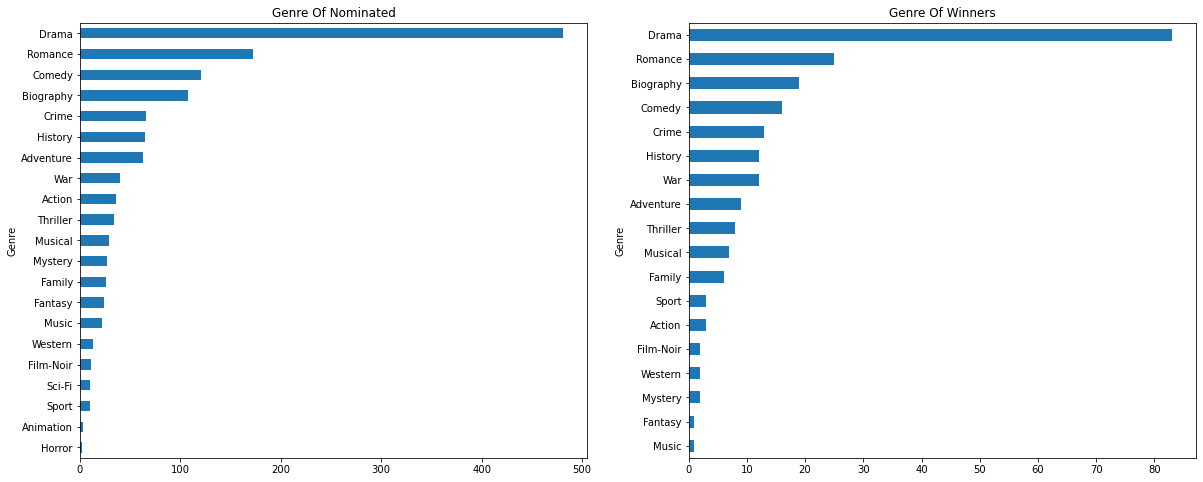

In [22]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
genres_sumN.sort_values().plot(kind='barh')
plt.title('Genre Of Nominated')
plt.ylabel('Genre')
plt.subplot(1,2,2)
genres_sumW.sort_values().plot(kind='barh')
plt.title('Genre Of Winners')
plt.ylabel('Genre')
plt.show()

First we take a look at how the genres are distributed, for nominations and winners.

We see that the most common winners/nominations are Drama, Romance, Biography, Comedy, Crime & History. This makes sense in the real world since movies with subject matters about people of history/wartime tend to be nominated at a higher rate, hence the "Oscar bait" films with these characteristics.

Now we take a look at every 2 pair of genres and see which tend to get nominated/win. To do this, we form a dot product of each one-hot encoded DF with itself and form a one-hot encoding on this resulting DF.
We do this for both genres and countries.

In [23]:
#Dot Product
genreN_dot = genres_nominated.T.dot(genres_nominated)
xlen = len(genreN_dot.index)
ylen = len(genreN_dot.columns)
genreN_df = pd.DataFrame([np.nan])

#Form One-hot Encoding for Paired Genres
while xlen > -1:
    while ylen > -1:
        if xlen != ylen:
            gColumn = genreN_dot.index[xlen - 1] + ', ' + genreN_dot.columns[ylen - 1]
            genreN_df[gColumn] = genreN_dot.loc[genreN_dot.index[xlen - 1], genreN_dot.columns[ylen - 1]]
            ylen -= 1
        else:
            ylen -= 1
            continue
    xlen -= 1
    ylen = xlen

#Drop any columns that didn't have values
genreN_df = genreN_df.drop(columns=0)
genreN_df = genreN_df.drop(columns=genreN_df.columns[(genreN_df == 0).all()])
genreN_df = genreN_df.T.sort_values(by=0).tail(20)

In [24]:
#Repeat for Countries
genreW_dot = genres_winners.T.dot(genres_winners)
xlen = len(genreW_dot.index)
ylen = len(genreW_dot.columns)
genreW_df = pd.DataFrame([np.nan])

while xlen > -1:
    while ylen > -1:
        if xlen != ylen:
            gColumn = genreW_dot.index[xlen - 1] + ', ' + genreW_dot.columns[ylen - 1]
            genreW_df[gColumn] = genreW_dot.loc[genreW_dot.index[xlen - 1], genreW_dot.columns[ylen - 1]]
            ylen -= 1
        else:
            ylen -= 1
            continue
    xlen -= 1
    ylen = xlen

genreW_df = genreW_df.drop(columns=0)
genreW_df = genreW_df.drop(columns=genreW_df.columns[(genreW_df == 0).all()])
genreW_df = genreW_df.T.sort_values(by=0).tail(20)

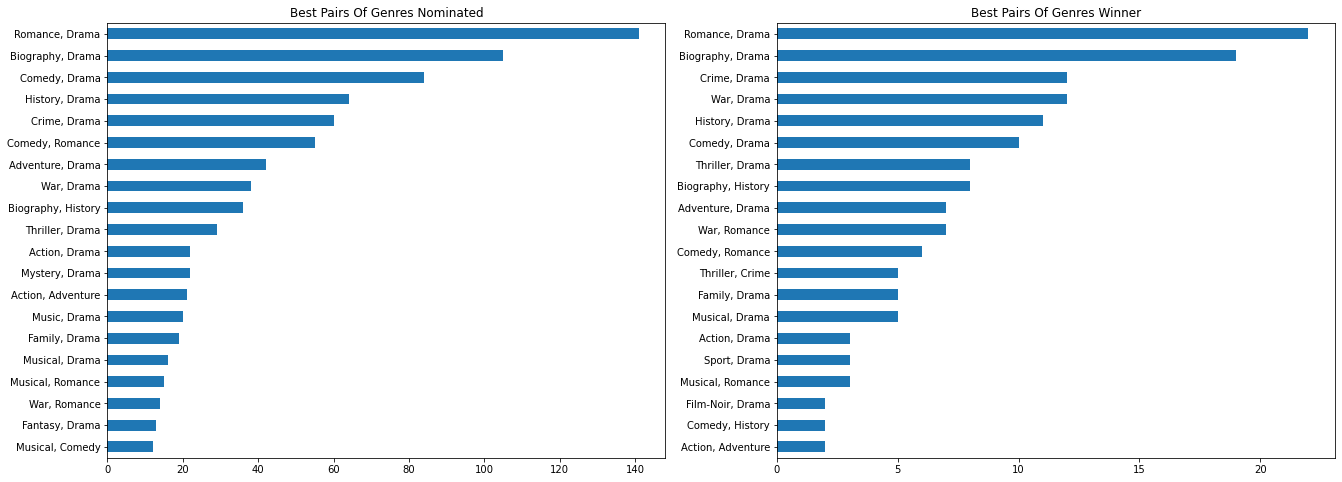

In [25]:
plt.figure(figsize=(22,8))
plt.subplot(1,2,1)
genreN_df.squeeze().plot(kind='barh',legend=False)
plt.title('Best Pairs Of Genres Nominated')

plt.subplot(1,2,2)
genreW_df.squeeze().plot(kind='barh',legend=False)
plt.title('Best Pairs Of Genres Winner')

plt.show()

We see from the bar charts above, the most common nominations/winners involve some sort of Romance/Drama and Biography/Drama. We again see the typical "Oscar bait" categories, like Crime/Drama and History/Drama in the winners and nominations, suggesting that Oscar voters lean towards certain types of films.\
Surprisingly, at least in my opinion, Comedy/Romance is 6th of nominated genres.

We can extend this evaluation to even more combinations of genres, but that can be for a later exercise.

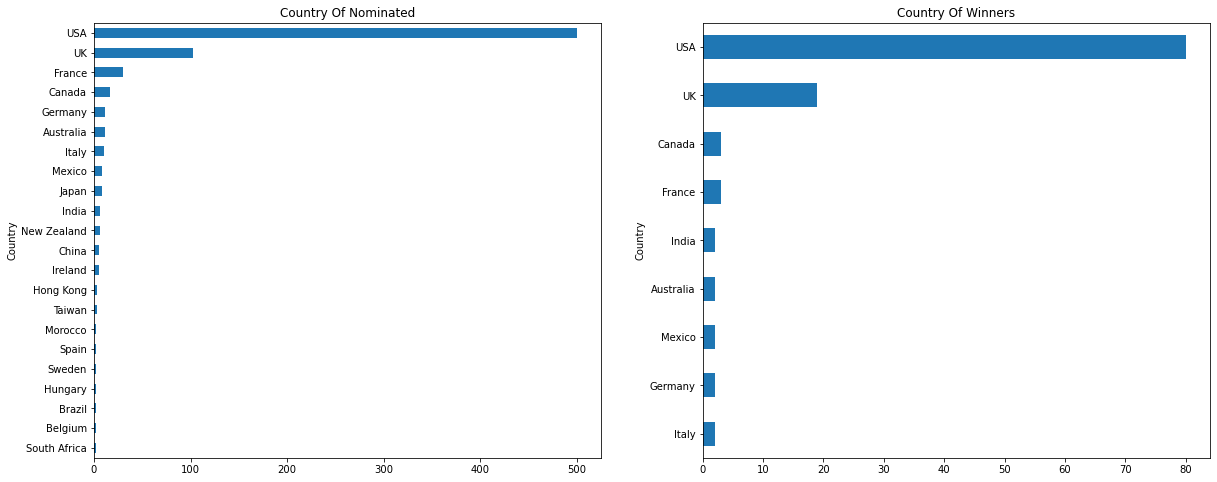

In [26]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
countries_sumN.sort_values().plot(kind='barh')
plt.title('Country Of Nominated')
plt.ylabel('Country')
plt.subplot(1,2,2)
countries_sumW.sort_values().plot(kind='barh')
plt.title('Country Of Winners')
plt.ylabel('Country')
plt.show()

Unsurprisingly, most of the winners were shown in the US. This just confirms what we already know that the Oscar winners/nominations haven't had a pure foreign winner until 2020, when *Parasite* won.

Now let's take a look at user ratings and metascore.

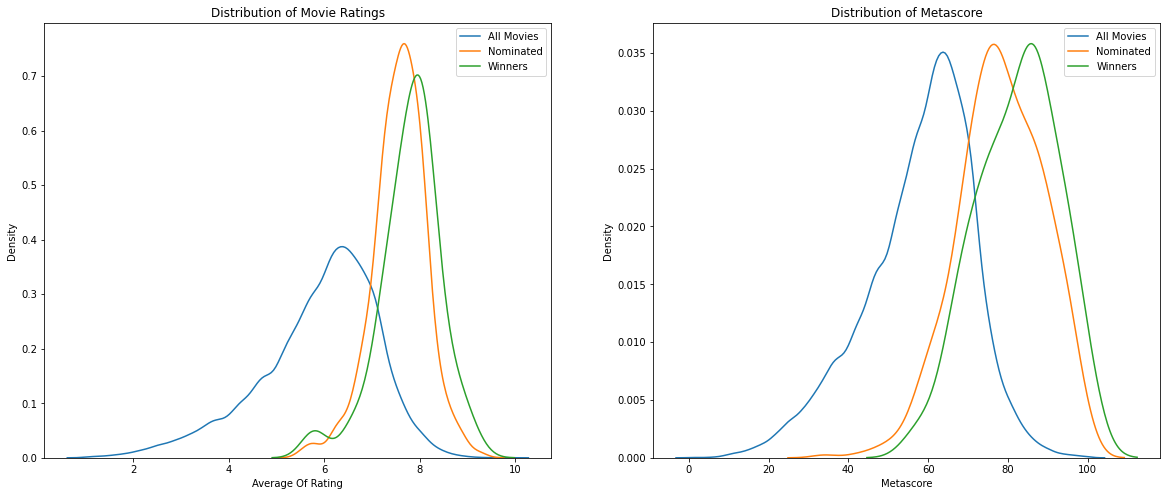

In [27]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.kdeplot(df['avg_vote'])
sns.kdeplot(df.loc[df['nominated'] == 1,'avg_vote'])
sns.kdeplot(df.loc[df['winner'] == 1,'avg_vote'])
plt.title('Distribution of Movie Ratings')
plt.xlabel('Average Of Rating')
plt.legend(['All Movies','Nominated','Winners'])

plt.subplot(1,2,2)
sns.kdeplot(df['metascore'])
sns.kdeplot(df.loc[df['nominated'] == 1,'metascore'])
sns.kdeplot(df.loc[df['winner'] == 1,'metascore'])
plt.title('Distribution of Metascore')
plt.xlabel('Metascore')
plt.legend(['All Movies','Nominated','Winners'])
plt.show()

Again, we expect the result that winners and nominations tend to have higher user ratings and metascores than the rest of the movies on IMDB, with winners having slightly higer ratings/scores than just nominated films.

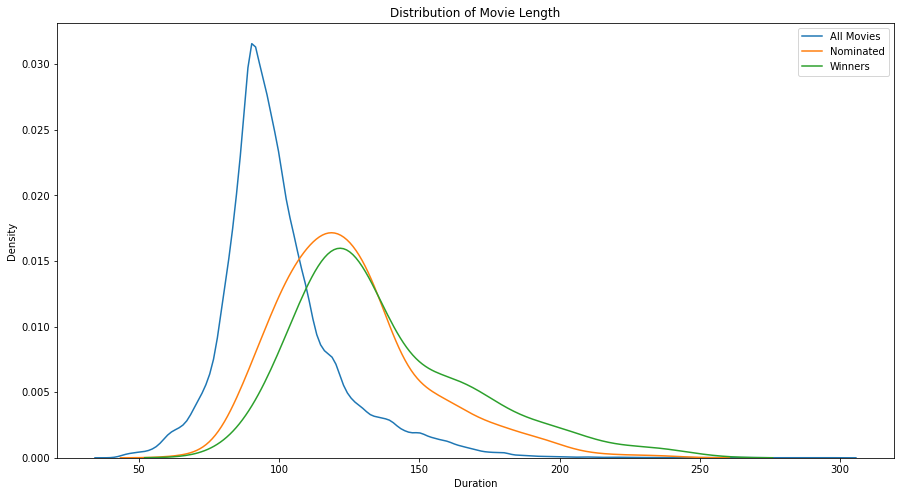

In [28]:
plt.figure(figsize=(15,8))
sns.kdeplot(df.loc[df['duration'] < 300, 'duration'])
sns.kdeplot(df.loc[df['nominated'] == 1,'duration'])
sns.kdeplot(df.loc[df['winner'] == 1,'duration'])
plt.title('Distribution of Movie Length')
plt.xlabel('Duration')
plt.legend(['All Movies','Nominated','Winners'])
plt.show()

From the distribution of duration, we see that movies that the average duration for a nominated/winner is around 2 hours, which is a bit higher than the average of movies in the IMDB database.

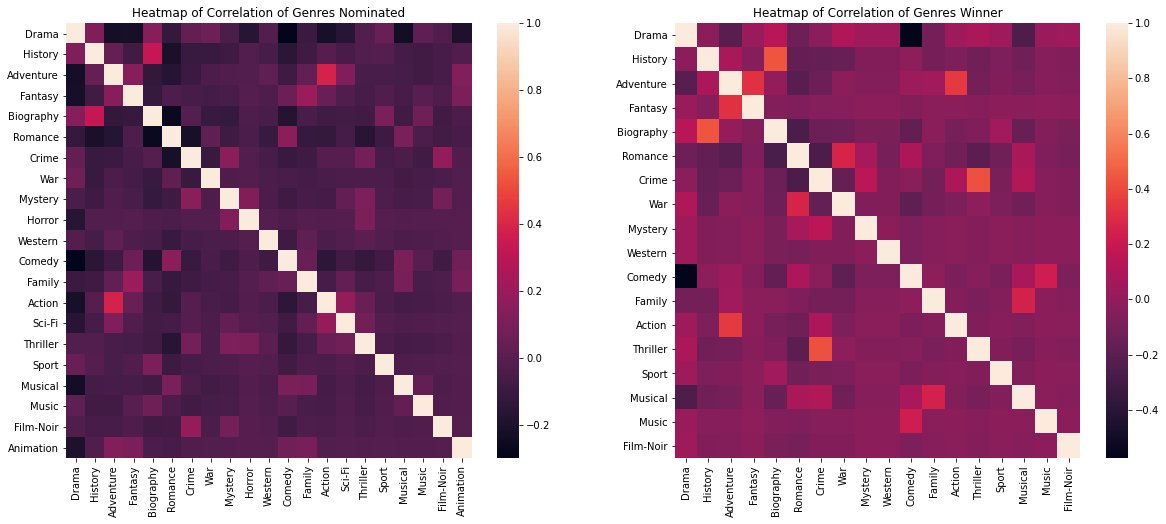

In [29]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.heatmap(genres_nominated.loc[:,genres_nominated.sum() > 0].corr())
plt.title('Heatmap of Correlation of Genres Nominated')
plt.subplot(1,2,2)
sns.heatmap(genres_winners.loc[:,genres_winners.sum() > 0].corr())
plt.title('Heatmap of Correlation of Genres Winner')
plt.show()

The above heatmap examines the relations between the genres for movies that are nominated/winner.\
We see the most highly correlated genres are Biography/History, Fantasy/Adventure, Action/Adventure, and Crime/Thriller. These are all very popular and common movie genres, so it would make sense that they are highyl correlated.


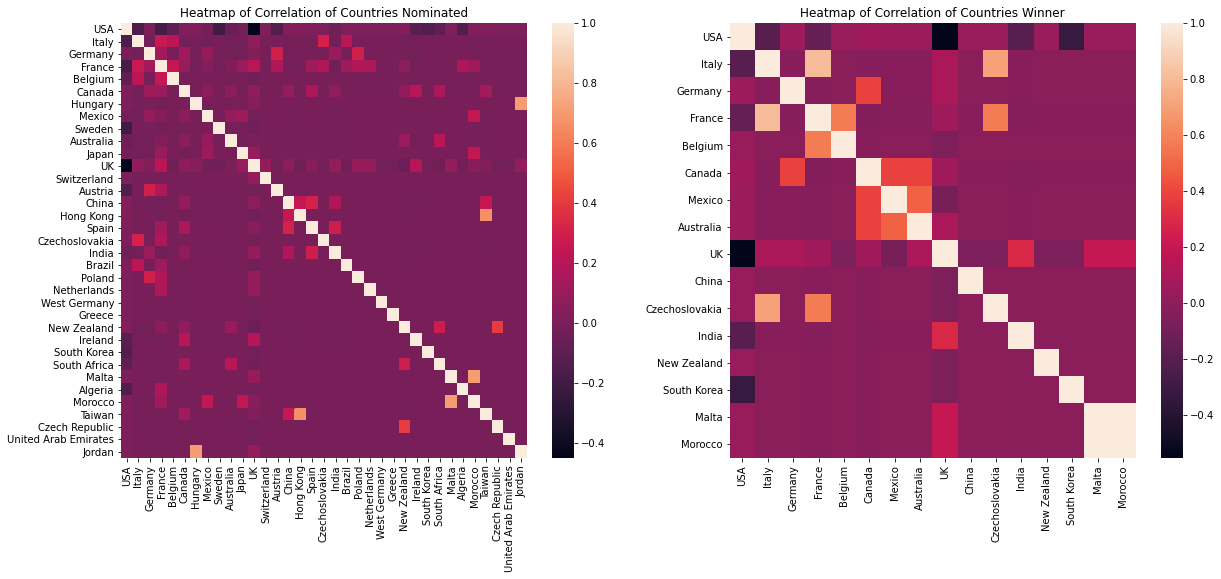

In [30]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.heatmap(countries_nominated.loc[:,countries_nominated.sum() > 0].corr())
plt.title('Heatmap of Correlation of Countries Nominated')
plt.subplot(1,2,2)
sns.heatmap(countries_winners.loc[:,countries_winners.sum() > 0].corr())
plt.title('Heatmap of Correlation of Countries Winner')
plt.show()

From the heatmap of the countries of winners/nominated, we see some strong correlation between Italy, France, and Belgium, as well as Canada, Mexico, and Australia.\
The US doesn't seem to have much correlation with any of the other countries.

## Machine Learning And Model Evaluation
Now we begin each to test each of the different ML algorithms for classification, and evaluate based on Jaccard Index, F1 Score, and Accuracy/Precision/Recall.\
The end result of these algorithms will hopefully produce models for nominations and winners separately. In our case, I decided to use nominated as a feature for winners, since all winners are firstly nominated. This means we have 2 different feature sets and 2 models in the end. We can use the model for nominations to use in the model for winners.


First, we have to make a few design choices on the features. I decided to remove metascore since we had imputed the data from avg votes for missing data. This would have caused a highly correlated and redundant feature.\
We take out the movies that are from 2020 and onwards, since those Oscars haven't happened yet.\
Then we have to scale the data to make the algorithms perform much better.\
Finally, we have to split the data into training and test sets for validation.


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, jaccard_score, f1_score, accuracy_score, recall_score, precision_score

#Remove all the movies that are above 2020 since Oscars haven't happened yet for 2021
df_copy = df.copy()
df_copy = df_copy[df['year'] < 2020]


#Drop all the unnecessary columns and take out the targets for winners and nominated.
yN = df_copy['nominated']
yW = df_copy['winner']
X_W = df_copy.drop(['original_title','year','metascore','genre','country','language','winner'], axis=1)

#We scale the continous data
X_W[['avg_vote','duration','votes']] = StandardScaler().fit(X_W[['avg_vote','duration','votes']]).transform(X_W[['avg_vote','duration','votes']])
X_N = X_W.drop(['nominated'], axis=1)

#Split training and test data
X_trainN, X_testN, y_trainN, y_testN = train_test_split(X_N, yN, test_size=0.2)
X_trainW, X_testW, y_trainW, y_testW = train_test_split(X_W, yW, test_size=0.2)


### Logistic Regression
We first try logisitic regression as a model.\
We have to tune the hyperparameters for the best performing one. The module GridSearchCV helps greatly with this process and chooses the best performing parameters.

Note that the following grid search takes a bit of time to finish, so I will comment this portion out and produce the best parameters afterwards.

In [32]:
# %%capture
# LR = LogisticRegression()
# penalty = ['l1','l2']
# C = np.logspace(0,4,10)
# maxiters =[1000]
# solver = ['newton-cg', 'lbfgs', 'liblinear']
# hyperparameters = dict(C=C, penalty=penalty, solver=solver, max_iter=maxiters)
# gridsearch = GridSearchCV(LR, hyperparameters, cv=4, verbose=0)
# bestN = gridsearch.fit(X_trainN, y_trainN)

In [33]:
#Best Params
#bestN.best_params_

{'C': 2.7825594022071245,
 'max_iter': 1000,
 'penalty': 'l2',
 'solver': 'liblinear'}

In [34]:
LR = LogisticRegression(C=2.7825594022971245, max_iter=1000, penalty = 'l2', solver = 'liblinear')
bestN = LR.fit(X_trainN, y_trainN)
yLR_N = bestN.predict(X_testN)

print('Jaccard Score is: {:.2}'.format(jaccard_score(y_testN, yLR_N)))
print('F1 Score is: {:.2}'.format(f1_score(y_testN, yLR_N)))
print('Accuracy is: {:.2}'.format(accuracy_score(y_testN, yLR_N)))
print('Precision is: {:.2}'.format(precision_score(y_testN, yLR_N)))
print('Recall is: {:.2}'.format(recall_score(y_testN, yLR_N)))

Jaccard Score is: 0.18
F1 Score is: 0.3
Accuracy is: 0.99
Precision is: 0.69
Recall is: 0.19


We see from the above that our scores aren't too good. In fact they are quite bad, indicating that our dataset is not much of a good indicator of predicting Oscar nominations.\
Let's see if this holds for winners as well.

We repeat the process of hyperparameter tuning and logistic regression, this time on the winners training set X_trainW.

In [35]:
# %%capture
# LR1 = LogisticRegression()
# gridsearch1 = GridSearchCV(LR1, hyperparameters, cv=4, verbose=0)
# bestW = gridsearch1.fit(X_trainW, y_trainW)

In [36]:
#bestW.best_params_

{'C': 1.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}

In [37]:
LR1 = LogisticRegression(C=1, max_iter=1000, penalty = 'l2', solver = 'liblinear')
bestW = LR1.fit(X_trainW, y_trainW)
yLR_W = bestW.predict(X_testW)

print('Jaccard Score is: {:.2}'.format(jaccard_score(y_testW, yLR_W)))
print('F1 Score is: {:.2}'.format(f1_score(y_testW, yLR_W)))
print('Accuracy is: {:.2}'.format(accuracy_score(y_testW, yLR_W)))
print('Precision is: {:.2}'.format(precision_score(y_testW, yLR_W)))
print('Recall is: {:.2}'.format(recall_score(y_testW, yLR_W)))

Jaccard Score is: 0.067
F1 Score is: 0.12
Accuracy is: 1.0
Precision is: 1.0
Recall is: 0.067


We see that performance is even worse for predicting winners. This makes intuitive sense since there are very few data points for winners, with nominations being about 5 times more.\
This would result in underfitting of the model and hence bad predictors of winners.\
Let's see for other types of algorithms.

### Decision Trees
Let's try Decision Trees. We keep most of the parameters of decision trees fixed as we don't want to set max leaves or nodes so the algorithm runs to completion.

In [38]:
decisiontree = DecisionTreeClassifier(random_state=0, criterion='entropy')
model_dtN = decisiontree.fit(X_trainN, y_trainN)
ydt_N = model_dtN.predict(X_testN)

print('Jaccard Score is: {:.2}'.format(jaccard_score(y_testN, ydt_N)))
print('F1 Score is: {:.2}'.format(f1_score(y_testN, ydt_N)))
print('Accuracy is: {:.2}'.format(accuracy_score(y_testN, ydt_N)))
print('Precision is: {:.2}'.format(precision_score(y_testN, ydt_N)))
print('Recall is: {:.2}'.format(recall_score(y_testN, ydt_N)))

decisiontree1 = DecisionTreeClassifier(random_state=0, criterion='entropy')
model_dtW = decisiontree1.fit(X_trainW, y_trainW)
ydt_W = model_dtW.predict(X_testW)

print('Jaccard Score is: {:.2}'.format(jaccard_score(y_testW, ydt_W)))
print('F1 Score is: {:.2}'.format(f1_score(y_testW, ydt_W)))
print('Accuracy is: {:.2}'.format(accuracy_score(y_testW, ydt_W)))
print('Precision is: {:.2}'.format(precision_score(y_testW, ydt_W)))
print('Recall is: {:.2}'.format(recall_score(y_testW, ydt_W)))

Jaccard Score is: 0.2
F1 Score is: 0.33
Accuracy is: 0.99
Precision is: 0.32
Recall is: 0.35
Jaccard Score is: 0.12
F1 Score is: 0.21
Accuracy is: 1.0
Precision is: 0.17
Recall is: 0.27


We see the scores are slightly better, especially the winners model.

### Random Forests
We expect similar performance as that of decision trees since a random forest uses multiple to arrive at a classification.

In [39]:
randomforest = RandomForestClassifier(criterion="entropy")
model_rfN = randomforest.fit(X_trainN, y_trainN)
yrf_N = model_rfN.predict(X_testN)

print('Jaccard Score is: {:.2}'.format(jaccard_score(y_testN, yrf_N)))
print('F1 Score is: {:.2}'.format(f1_score(y_testN, yrf_N)))
print('Accuracy is: {:.2}'.format(accuracy_score(y_testN, yrf_N)))
print('Precision is: {:.2}'.format(precision_score(y_testN, yrf_N)))
print('Recall is: {:.2}'.format(recall_score(y_testN, yrf_N)))

randomforest1 = RandomForestClassifier(criterion="entropy")
model_rfW = randomforest1.fit(X_trainW, y_trainW)
yrf_W = model_rfW.predict(X_testW)

print('Jaccard Score is: {:.2}'.format(jaccard_score(y_testW, yrf_W)))
print('F1 Score is: {:.2}'.format(f1_score(y_testW, yrf_W)))
print('Accuracy is: {:.2}'.format(accuracy_score(y_testW, yrf_W)))
print('Precision is: {:.2}'.format(precision_score(y_testW, yrf_W)))
print('Recall is: {:.2}'.format(recall_score(y_testW, yrf_W)))

Jaccard Score is: 0.17
F1 Score is: 0.29
Accuracy is: 0.99
Precision is: 0.68
Recall is: 0.18
Jaccard Score is: 0.062
F1 Score is: 0.12
Accuracy is: 1.0
Precision is: 0.5
Recall is: 0.067


As expected, we achieve similar results as that of the decision tree algorithm.

### K Nearest Neighbors
We don't expect this algorithm to perform very well, mainly since the dataset is a bit large and that the movies aren't very split apart intuitively since only a fixed number of movies can be nominated/win each year.
Nevertheless, we use gridsearch again to find the best N value and find the scores.
I will comment this portion out since this grid search takes some time.

In [40]:
# knn = KNeighborsClassifier()
# n_neighbors = np.arange(2,30)
# hyperparameters = dict(n_neighbors=n_neighbors)
# gridsearch_knn = GridSearchCV(knn, hyperparameters, cv=4, verbose=0)
# model_knnN = gridsearch_knn.fit(X_trainN, y_trainN)

In [186]:
#gridsearch_knn.best_params_

{'n_neighbors': 10}

In [40]:
knn = KNeighborsClassifier(n_neighbors=10)
model_knnN = knn.fit(X_trainN, y_trainN)
yknn_N = model_knnN.predict(X_testN)

print('Jaccard Score is: {:.2}'.format(jaccard_score(y_testN, yknn_N)))
print('F1 Score is: {:.2}'.format(f1_score(y_testN, yknn_N)))
print('Accuracy is: {:.2}'.format(accuracy_score(y_testN, yknn_N)))
print('Precision is: {:.2}'.format(precision_score(y_testN, yknn_N)))
print('Recall is: {:.2}'.format(recall_score(y_testN, yknn_N)))

Jaccard Score is: 0.065
F1 Score is: 0.12
Accuracy is: 0.99
Precision is: 0.47
Recall is: 0.07


In [41]:
# knn1 = KNeighborsClassifier()
# gridsearch_knnW = GridSearchCV(knn1, hyperparameters, cv=4, verbose=0)
# model_knnW = gridsearch_knnW.fit(X_trainW, y_trainW)

In [187]:
#gridsearch_knnW.best_params_

{'n_neighbors': 8}

In [41]:
knn1 = KNeighborsClassifier(n_neighbors=8)
model_knnW = knn1.fit(X_trainW, y_trainW)
yknn_W = model_knnW.predict(X_testW)

print('Jaccard Score is: {:.2}'.format(jaccard_score(y_testW, yknn_W)))
print('F1 Score is: {:.2}'.format(f1_score(y_testW, yknn_W)))
print('Accuracy is: {:.2}'.format(accuracy_score(y_testW, yknn_W)))
print('Precision is: {:.2}'.format(precision_score(y_testW, yknn_W)))
print('Recall is: {:.2}'.format(recall_score(y_testW, yknn_W)))

Jaccard Score is: 0.0
F1 Score is: 0.0
Accuracy is: 1.0
Precision is: 0.0
Recall is: 0.0


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Naive Bayes
We don't expect this to be the best predictor either since Naive Bayes usually does not work well with larger datasets.\
We have to use the Gaussian version since we have both continous and categorical features in our data.

In [42]:
naive_bayes = GaussianNB()
model_nbN = naive_bayes.fit(X_trainN, y_trainN)
ynb_N = model_nbN.predict(X_testN)

print('Jaccard Score is: {:.2}'.format(jaccard_score(y_testN, ynb_N)))
print('F1 Score is: {:.2}'.format(f1_score(y_testN, ynb_N)))
print('Accuracy is: {:.2}'.format(accuracy_score(y_testN, ynb_N)))
print('Precision is: {:.2}'.format(precision_score(y_testN, ynb_N)))
print('Recall is: {:.2}'.format(recall_score(y_testN, ynb_N)))

naive_bayes1 = GaussianNB()
model_nbW = naive_bayes1.fit(X_trainW, y_trainW)
ynb_W = model_nbW.predict(X_testW)

print('Jaccard Score is: {:.2}'.format(jaccard_score(y_testW, ynb_W)))
print('F1 Score is: {:.2}'.format(f1_score(y_testW, ynb_W)))
print('Accuracy is: {:.2}'.format(accuracy_score(y_testW, ynb_W)))
print('Precision is: {:.2}'.format(precision_score(y_testW, ynb_W)))
print('Recall is: {:.2}'.format(recall_score(y_testW, ynb_W)))

Jaccard Score is: 0.0081
F1 Score is: 0.016
Accuracy is: 0.19
Precision is: 0.0081
Recall is: 0.97
Jaccard Score is: 0.13
F1 Score is: 0.23
Accuracy is: 0.99
Precision is: 0.13
Recall is: 0.87


Surprisingly, the winners predictor is on level with the performance of the other classification algorithms earlier.

### Summary of results
Let's put all of the scores into a tables for comparison.

In [43]:
scores_nominated = pd.DataFrame({'Logisitic':[jaccard_score(y_testN, yLR_N),f1_score(y_testN, yLR_N),accuracy_score(y_testN, yLR_N),precision_score(y_testN, yLR_N),recall_score(y_testN, yLR_N)],\
                                'Decision Tree':[jaccard_score(y_testN, ydt_N),f1_score(y_testN, ydt_N),accuracy_score(y_testN, ydt_N),precision_score(y_testN, ydt_N),recall_score(y_testN, ydt_N)],\
                                'Random Forest':[jaccard_score(y_testN, yrf_N),f1_score(y_testN, yrf_N),accuracy_score(y_testN, yrf_N),precision_score(y_testN, yrf_N),recall_score(y_testN, yrf_N)],\
                                'KNN':[jaccard_score(y_testN, yknn_N),f1_score(y_testN, yknn_N),accuracy_score(y_testN, yknn_N),precision_score(y_testN, yknn_N),recall_score(y_testN, yknn_N)],\
                                'Naive Bayes':[jaccard_score(y_testN, ynb_N),f1_score(y_testN, ynb_N),accuracy_score(y_testN, ynb_N),precision_score(y_testN, ynb_N),recall_score(y_testN, ynb_N)]},
                                index=['Jaccard','F1','Accuracy','Precision','Recall'])

In [44]:
scores_nominated.round(3)

,Logisitic,Decision Tree,Random Forest,KNN,Naive Bayes
Jaccard,0.176,0.199,0.168,0.065,0.008
F1,0.299,0.332,0.288,0.121,0.016
Accuracy,0.994,0.990,0.994,0.993,0.188
Precision,0.688,0.317,0.677,0.471,0.008
Recall,0.191,0.348,0.183,0.070,0.974


In [45]:
scores_winner = pd.DataFrame({'Logisitic':[jaccard_score(y_testW, yLR_W),f1_score(y_testW, yLR_W),accuracy_score(y_testW, yLR_W),precision_score(y_testW, yLR_W),recall_score(y_testW, yLR_W)],\
                                'Decision Tree':[jaccard_score(y_testW, ydt_W),f1_score(y_testW, ydt_W),accuracy_score(y_testW, ydt_W),precision_score(y_testW, ydt_W),recall_score(y_testW, ydt_W)],\
                                'Random Forest':[jaccard_score(y_testW, yrf_W),f1_score(y_testW, yrf_W),accuracy_score(y_testW, yrf_W),precision_score(y_testW, yrf_W),recall_score(y_testW, yrf_W)],\
                                'KNN':[jaccard_score(y_testW, yknn_W),f1_score(y_testW, yknn_W),accuracy_score(y_testW, yknn_W),precision_score(y_testW, yknn_W),recall_score(y_testW, yknn_W)],\
                                'Naive Bayes':[jaccard_score(y_testW, ynb_W),f1_score(y_testW, ynb_W),accuracy_score(y_testW, ynb_W),precision_score(y_testW, ynb_W),recall_score(y_testW, ynb_W)]},
                                index=['Jaccard','F1','Accuracy','Precision','Recall'])

D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
scores_winner.round(3)

,Logisitic,Decision Tree,Random Forest,KNN,Naive Bayes
Jaccard,0.067,0.118,0.062,0.000,0.130
F1,0.125,0.211,0.118,0.000,0.230
Accuracy,0.999,0.998,0.999,0.999,0.995
Precision,1.000,0.174,0.500,0.000,0.133
Recall,0.067,0.267,0.067,0.000,0.867


We conclude that for nominations, we can use Logistic Regression, Decision Tree and Random Forest algorithms for nominations, with Decision Trees having slightly better performance than the rest.\
However, since Decision Trees don't give exact probabilities by nature of the algorithm, Random Forest or Logisitic Regression seem like the best choice.

For winners, we see that Decision Trees, Random Forest and Naive Bayes algorithms work best, with Random Forest having the highest precision.\
Now we can try to predict the nominations and winners for 2020 using these models.

## Predicting Nominations and Winner of 2020
First, we have to format the 2020 data to use the same features as the training sets of the models.

In [47]:
df_2020 = df[(df['year'] == 2020)].drop(['original_title','year','genre','language','country','metascore','winner','nominated'], axis=1)
df_2020[['avg_vote','duration','votes']] = StandardScaler().fit(df_2020[['avg_vote','duration','votes']]).transform(df_2020[['avg_vote','duration','votes']])

### Nominations
We go through each of our nomination classifiers and see which movies appear in the top 20 of each. Note that for Decision Tree, the probabilities are only 1 or 0, which is the nature of the algorithm.

#### Logistic Regression

In [60]:
LR_2020 = bestN.predict_proba(df_2020)
df_2020_noms_LR = df[df['year'] == 2020][['original_title']]
df_2020_noms_LR['Prob of Nominated'] = pd.Series(LR_2020[:,1],index=df_2020_noms_LR.index)
sorted_Nom_LR = df_2020_noms_LR.sort_values(by='Prob of Nominated',ascending=False)
sorted_Nom_LR.reset_index().drop('index',axis=1).head(10)

,original_title,Prob of Nominated
0,Hamilton,0.904060
1,Canaan Land,0.734972
2,I Flip You Off for Four Hours,0.506448
3,The Trial of the Chicago 7,0.444455
4,A House Divided... A Mega Maga Movie,0.246276
5,The Moving on Phase,0.222158
6,Interview with the Antichrist,0.163426
7,Chronicle of a Serial Killer,0.162498
8,Talita,0.154780
9,The Banker,0.143957


#### Decision Tree

In [61]:
DT_2020 = model_dtN.predict_proba(df_2020)
df_2020_noms_DT = df[df['year'] == 2020][['original_title']]
df_2020_noms_DT['Prob of Nominated'] = pd.Series(DT_2020[:,1],index=df_2020_noms_DT.index)
sorted_Nom_DT = df_2020_noms_DT.sort_values(by='Prob of Nominated',ascending=False)
sorted_Nom_DT.reset_index().drop('index',axis=1).head(10)

,original_title,Prob of Nominated
0,The Trial of the Chicago 7,1.0
1,Clouds,1.0
2,The Devil All the Time,1.0
3,The Invisible Man,1.0
4,Hamilton,1.0
5,The Party Planner,0.0
6,A Little Red Flower,0.0
7,Kill Mode,0.0
8,Maska,0.0
9,The One You Feed,0.0


#### Random Forest

In [66]:
RF_2020 = model_rfN.predict_proba(df_2020)
df_2020_noms_RF = df[df['year'] == 2020][['original_title']]
df_2020_noms_RF['Prob of Nominated'] = pd.Series(RF_2020[:,1],index=df_2020_noms_RF.index)
sorted_Nom_RF = df_2020_noms_RF.sort_values(by='Prob of Nominated',ascending=False)
sorted_Nom_RF.reset_index().drop('index',axis=1).head(10)

,original_title,Prob of Nominated
0,The Trial of the Chicago 7,0.62
1,Hamilton,0.60
2,Minari,0.35
3,Never Rarely Sometimes Always,0.26
4,Nomadland,0.19
5,Interreflections,0.19
6,The Half of It,0.17
7,Emma.,0.16
8,The King of Staten Island,0.16
9,Chemical Hearts,0.16


#### K-Nearest Neighbors

In [64]:
knn_2020 = model_knnN.predict_proba(df_2020)
df_2020_noms_knn = df[df['year'] == 2020][['original_title']]
df_2020_noms_knn['Prob of Nominated'] = pd.Series(knn_2020[:,1],index=df_2020_noms_knn.index)
sorted_Nom_knn = df_2020_noms_knn.sort_values(by='Prob of Nominated',ascending=False)
sorted_Nom_knn.reset_index().drop('index',axis=1).head(10)

,original_title,Prob of Nominated
0,Hamilton,0.5
1,The Invisible Man,0.4
2,Dara of Jasenovac,0.4
3,Da 5 Bloods,0.3
4,Rebecca,0.3
5,Interreflections,0.3
6,Last Call,0.3
7,The Trial of the Chicago 7,0.2
8,Greyhound,0.2
9,Another Round,0.2


#### Naive Bayes
We note that the results are a bit skewed for this algorithm, which was shown given the scores from before. Hence, it is best that we discard this classifier for nominations.

In [65]:
NB_2020 = model_nbN.predict_proba(df_2020)
df_2020_noms_NB = df[df['year'] == 2020][['original_title']]
df_2020_noms_NB['Prob of Nominated'] = pd.Series(NB_2020[:,1],index=df_2020_noms_NB.index)
sorted_Nom_NB = df_2020_noms_NB.sort_values(by='Prob of Nominated',ascending=False)
sorted_Nom_NB.reset_index().drop('index',axis=1).head(10)

,original_title,Prob of Nominated
0,The Party Planner,1.0
1,The Source of Shadows,1.0
2,Secret Zoo,1.0
3,Non odiare,1.0
4,Disclosure,1.0
5,La mia banda suona il pop,1.0
6,Chocolate Covered Christmas,1.0
7,Sab Kushal Mangal,1.0
8,Active Shooter,1.0
9,Seriously Single,1.0


We can now average all the probability values of each of the classifiers to see the average result among all the classifiers. I will use the Jaccard scores as the weights of these averages.

In [137]:
df_2020_noms = df[df['year'] == 2020][['original_title']]

In [144]:
df_2020_noms['LR Prob'] = df_2020_noms_LR['Prob of Nominated'] * jaccard_score(y_testN, yLR_N)
df_2020_noms['DT Prob'] = df_2020_noms_DT['Prob of Nominated'] * jaccard_score(y_testN, ydt_N)
df_2020_noms['RF Prob'] = df_2020_noms_RF['Prob of Nominated'] * jaccard_score(y_testN, yrf_N)
df_2020_noms['KNN Prob'] = df_2020_noms_knn['Prob of Nominated'] * jaccard_score(y_testN, yknn_N)
df_2020_noms['Total'] = (df_2020_noms['LR Prob'] + df_2020_noms['DT Prob'] + df_2020_noms['RF Prob'] + df_2020_noms['KNN Prob']) / 4

In [145]:
sorted_noms = df_2020_noms.sort_values(by='Total',ascending=False)
sorted_noms.reset_index().drop('index',axis=1)[['original_title','Total']].head(20)

,original_title,Total
0,Hamilton,0.122794
1,The Trial of the Chicago 7,0.098573
2,Clouds,0.059960
3,The Devil All the Time,0.058664
4,The Invisible Man,0.057937
5,Canaan Land,0.033179
6,I Flip You Off for Four Hours,0.025644
7,Minari,0.022854
8,Never Rarely Sometimes Always,0.016725
9,Nomadland,0.015459


This is the list of nominations that we end up with using our classifiers. It is of course not perfect given our dataset. For instance, we can disqualify some of these entries purely by going through what the movies actually are on IMDB. Movies like "Canaan Land" and "I Flip You Off for Four Hours" seem like they are unlikely to be nominated, but they fit the requirements on IMDB.\
Also, we have to note that the Decision Tree algorithm affects this weighted sum heavily due to the nature of the probabilities.

### Winner

Now we move on to the winners. We have to populate the nominated feature column since we decided to use this for our models.\
We can decide to use one of the predicted results from the nominated models. For this case, I chose Random Forest, but we can decide on Decision Tree or Logistic Regression. Note that the choice of nominations will affect the winner prediction heavily.

In [102]:
df_2020_W = df_2020.copy()
nom_predicted_2020 = model_rfN.predict(df_2020) #Use Decision Tree as values for nominated column for winner classifiers
df_2020_W.insert(3,'nominated',pd.Series(DT_2020_array,index=df_2020_W.index)) #Put nominated column in the correct column index

#### Logisitic Regression

In [103]:
LR_2020_W = bestW.predict_proba(df_2020_W)
df_2020_win_LR = df[df['year'] == 2020][['original_title']]
df_2020_win_LR['Prob of Nominated'] = pd.Series(LR_2020_W[:,1],index=df_2020_win_LR.index)
sorted_win_LR = df_2020_win_LR.sort_values(by='Prob of Nominated',ascending=False)
sorted_win_LR.reset_index().drop('index',axis=1).head(10)

,original_title,Prob of Nominated
0,Hamilton,0.286297
1,The Trial of the Chicago 7,0.205572
2,The Devil All the Time,0.140326
3,The Invisible Man,0.082852
4,Clouds,0.073250
5,I Flip You Off for Four Hours,0.003447
6,Little Mix: LM5 - The Tour Film,0.002086
7,A Carolina Christmas,0.001718
8,Dara of Jasenovac,0.001638
9,Flukten over grensen,0.001570


#### Decision Tree

In [104]:
DT_2020_W = model_dtW.predict_proba(df_2020_W)
df_2020_win_DT = df[df['year'] == 2020][['original_title']]
df_2020_win_DT['Prob of Nominated'] = pd.Series(DT_2020_W[:,1],index=df_2020_win_DT.index)
sorted_win_DT = df_2020_win_DT.sort_values(by='Prob of Nominated',ascending=False)
sorted_win_DT.reset_index().drop('index',axis=1).head(10)

,original_title,Prob of Nominated
0,The Trial of the Chicago 7,1.0
1,The Invisible Man,1.0
2,Hamilton,1.0
3,The Party Planner,0.0
4,A Little Red Flower,0.0
5,Kill Mode,0.0
6,Maska,0.0
7,The One You Feed,0.0
8,Terrible Jungle,0.0
9,Love on the Rise,0.0


#### Random Forest

In [105]:
RF_2020_W = model_rfW.predict_proba(df_2020_W)
df_2020_win_RF = df[df['year'] == 2020][['original_title']]
df_2020_win_RF['Prob of Nominated'] = pd.Series(RF_2020_W[:,1],index=df_2020_win_RF.index)
sorted_win_RF = df_2020_win_RF.sort_values(by='Prob of Nominated',ascending=False)
sorted_win_RF.reset_index().drop('index',axis=1).head(10)

,original_title,Prob of Nominated
0,Hamilton,0.43
1,The Devil All the Time,0.12
2,Clouds,0.11
3,The Trial of the Chicago 7,0.07
4,The Invisible Man,0.05
5,Minari,0.02
6,Dance of the 41,0.01
7,Da 5 Bloods,0.01
8,Emma.,0.01
9,Tanhaji: The Unsung Warrior,0.01


#### K-Nearest Neighbors

In [106]:
knn_2020_W = model_knnW.predict_proba(df_2020_W)
df_2020_win_knn = df[df['year'] == 2020][['original_title']]
df_2020_win_knn['Prob of Nominated'] = pd.Series(knn_2020_W[:,1],index=df_2020_win_knn.index)
sorted_win_knn = df_2020_win_knn.sort_values(by='Prob of Nominated',ascending=False)
sorted_win_knn.reset_index().drop('index',axis=1).head(10)

,original_title,Prob of Nominated
0,The Invisible Man,0.375
1,The Trial of the Chicago 7,0.125
2,Clouds,0.125
3,Hamilton,0.125
4,The Party Planner,0.000
5,A Little Red Flower,0.000
6,Kill Mode,0.000
7,Maska,0.000
8,The One You Feed,0.000
9,Terrible Jungle,0.000


#### Naive Bayes

In [107]:
NB_2020_W = model_nbW.predict_proba(df_2020_W)
df_2020_win_NB = df[df['year'] == 2020][['original_title']]
df_2020_win_NB['Prob of Nominated'] = pd.Series(NB_2020_W[:,1],index=df_2020_win_NB.index)
sorted_win_NB = df_2020_win_NB.sort_values(by='Prob of Nominated',ascending=False)
sorted_win_NB.reset_index().drop('index',axis=1).head(10)

,original_title,Prob of Nominated
0,Clouds,1.0
1,The Devil All the Time,1.0
2,Hamilton,1.0
3,The Trial of the Chicago 7,1.0
4,The Party Planner,0.0
5,The Curse of Hobbes House,0.0
6,A Little Red Flower,0.0
7,Kill Mode,0.0
8,Maska,0.0
9,The One You Feed,0.0


Again, we use the strategy of weighted average of the probabilities. This time, we can use the Naive Bayes as it is more accurate.

In [136]:
df_2020_win = df[df['year'] == 2020][['original_title']]

In [142]:
df_2020_win['LR Prob'] = df_2020_win_LR['Prob of Nominated'] * jaccard_score(y_testW, yLR_W)
df_2020_win['DT Prob'] = df_2020_win_DT['Prob of Nominated'] * jaccard_score(y_testW, ydt_W)
df_2020_win['RF Prob'] = df_2020_win_RF['Prob of Nominated'] * jaccard_score(y_testW, yrf_W)
df_2020_win['KNN Prob'] = df_2020_win_knn['Prob of Nominated'] * jaccard_score(y_testW, yknn_W)
df_2020_win['NB Prob'] = df_2020_win_NB['Prob of Nominated'] * jaccard_score(y_testW, ynb_W)
df_2020_win['Total'] = (df_2020_win['LR Prob'] + df_2020_win['DT Prob'] + df_2020_win['RF Prob'] + df_2020_win['KNN Prob'] + df_2020_win['NB Prob']) / 5

In [143]:
sorted_win = df_2020_win.sort_values(by='Total',ascending=False)
sorted_win.reset_index().drop('index',axis=1)[['original_title','Total']].head(20)

,original_title,Total
0,Hamilton,0.058722
1,The Trial of the Chicago 7,0.053145
2,The Devil All the Time,0.029371
3,Clouds,0.028352
4,The Invisible Man,0.025259
5,Minari,0.000256
6,I Flip You Off for Four Hours,0.000171
7,Soorarai Pottru,0.000138
8,Dance of the 41,0.000134
9,Da 5 Bloods,0.000134


## Final Results and Next Steps

Let's put both of the results of nominations and winners together and visualize the probabilities.

In [174]:
df_final = df[df['year'] == 2020][['original_title']]
df_final['Prob Nominated'] = df_2020_noms['Total']
df_final['Prob Winner'] = df_2020_win['Total']

#Scale the data to make probabilities make more sense
df_final[['Prob Nominated','Prob Winner']] = MinMaxScaler().fit(df_final[['Prob Nominated','Prob Winner']]).transform(df_final[['Prob Nominated','Prob Winner']])
df_final.set_index('original_title',inplace=True)
df_final.index.name = None
sorted_final = df_final.sort_values(by='Prob Winner', ascending=False)
sorted_final.round(3).head(20)

,Prob Nominated,Prob Winner
Hamilton,1.000,1.000
The Trial of the Chicago 7,0.803,0.905
The Devil All the Time,0.478,0.500
Clouds,0.488,0.483
The Invisible Man,0.472,0.430
Minari,0.186,0.004
I Flip You Off for Four Hours,0.209,0.003
Soorarai Pottru,0.049,0.002
Dance of the 41,0.023,0.002
Da 5 Bloods,0.099,0.002


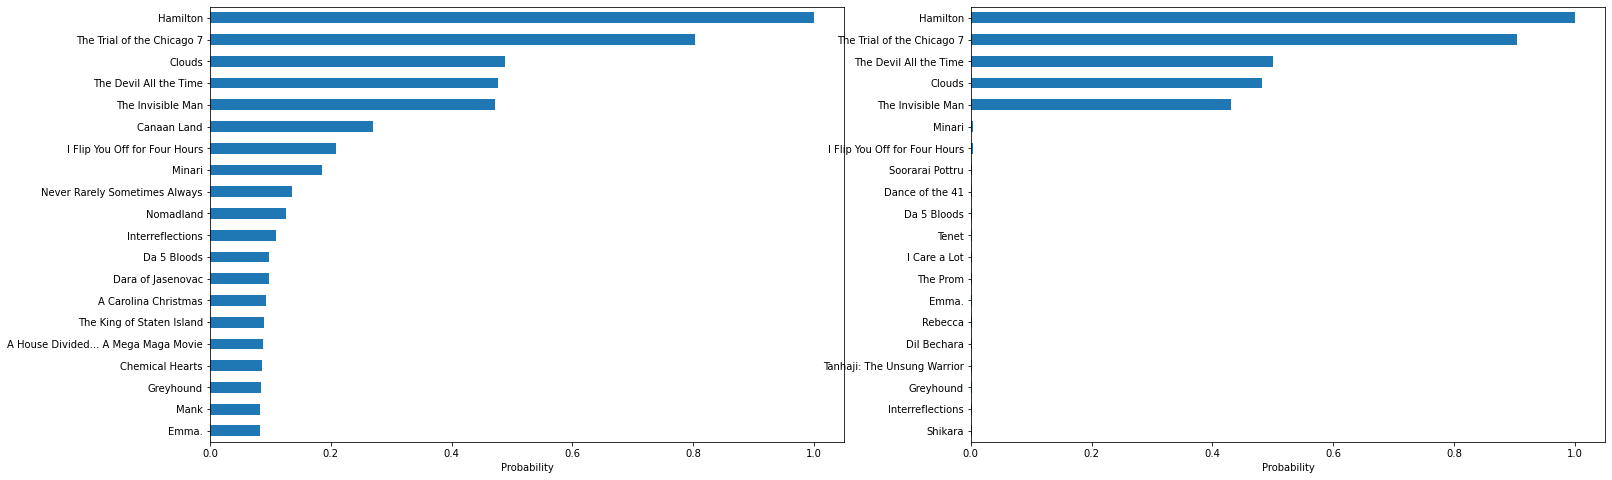

In [183]:
plt.figure(figsize=(25,8))
plt.subplot(1,2,1)
df_final['Prob Nominated'].sort_values().tail(20).plot(kind='barh')
plt.xlabel('Probability')
plt.subplot(1,2,2)
df_final['Prob Winner'].sort_values().tail(20).plot(kind='barh')
plt.xlabel('Probability')
plt.show()

### Next Steps
This project was done for the 2021 Oscars, but can be extended for Oscars in future years. This would simply require the dataset to be updated, which can be done via web-scraping.

There is a lot more that can be done to make this model more accurate. For instance, we can include more critics scores like Rotten Tomatoes or Metacritic. We can also use other award shows to see who were the nominations and winners of those to predict the winner.\
Furthermore, because the Oscars itself is a very campaign-based award, we can do some NLP analysis on movie reviews each year to see which movies are the most likely to get nominated or get buzz.\
These are all implementations that could be added to this project and could be explored further.\
There can also be some predictions done for the other categories of the Oscars.